# Adaptive Rejection Sampling

In [110]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.integrate import quad
from numpy.random import rand, seed, random_sample

In [111]:
%config InlineBackend.figure_format = "retina"

In [112]:
a, b = 3, 2
p = beta(a=a, b=b)

In [113]:
seed(3141592653)
z0 = p.rvs(3)

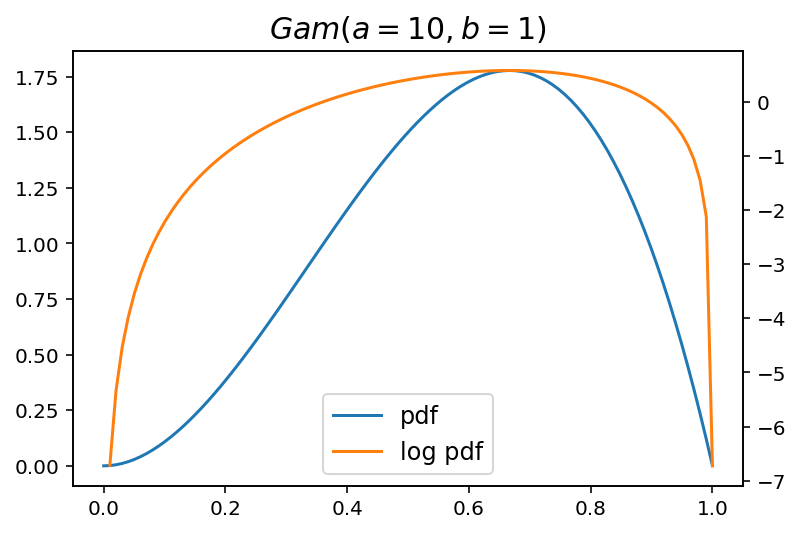

In [114]:
xrange = np.linspace(0, 0.9999, 100)

fig, ax = plt.subplots()
ax2 = ax.twinx()
l1 = ax.plot(xrange, p.pdf(xrange), label="pdf")
l2 = ax2.plot(xrange, p.logpdf(xrange), c="tab:orange", label="log pdf")
l = l1 + l2
labels = [l.get_label() for l in l]
ax.set_title(r"$Gam(a=10,b=1)$", fontsize=15)
plt.legend(l, labels, fontsize=12);

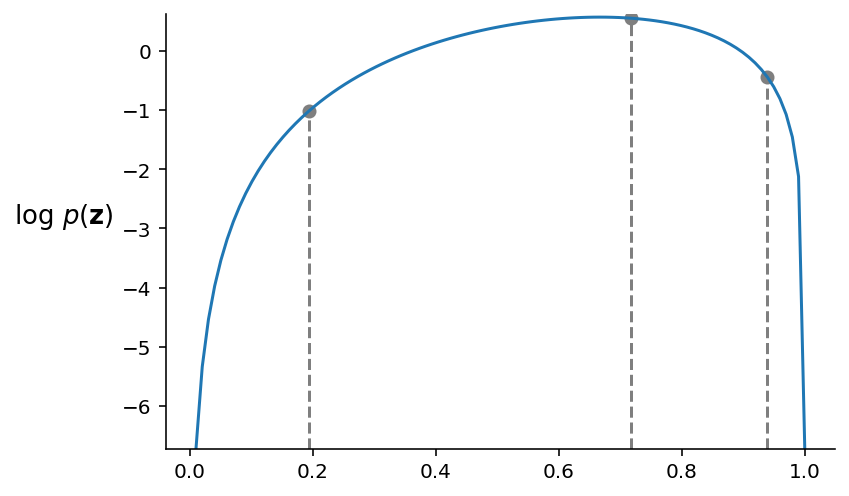

In [115]:
p_logpdf = p.logpdf(xrange)

fig, ax = plt.subplots()
ax.plot(xrange, p_logpdf, label="pdf")
ax.scatter(z0, p.logpdf(z0), color="tab:gray")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

lower_bound = p_logpdf[~np.isinf(p_logpdf)].min()
upper_bound = p_logpdf.max() * 1.1

for z in z0:
    ax.vlines(z, lower_bound, p.logpdf(z), color="tab:gray", linestyle="--")
ax.set_ylim(lower_bound, upper_bound)
ax.set_ylabel(r"$\log \ p({\bf z})$", fontsize=13,
           rotation=0,
           horizontalalignment="right");

In [116]:
def finite_approx(f, x, eps=1e-5):
    return (f(x + eps) - f(x - eps)) / (2 * eps)

In [117]:
z = np.sort(z0)
lambda_n = finite_approx(p.logpdf, z)
lambda_n

array([  9.10271003,  -0.76087912, -14.22522469])

In [118]:
def compute_intersect(x1, x2, f, eps=1e-5):
    """
    Compute the x-value that intersects two lines
    of the form
    yi = li * (x - xi) + f(zi)
    
    Parameters
    ----------
    x1, x2: float
        The tangent points
    f: function
        the target function
    """
    l1 = finite_approx(f, x1, eps=eps)
    l2 = finite_approx(f, x2, eps=eps)
    den = (l1 - l2)
    num = f(x2) - f(x1) + l1 * x1 - l2 * x2
    return num / den


def tangent_line(zi, z1, f, eps=1e-5):
    return finite_approx(f, z1, eps=eps) * (zi - z1) + f(z1)


def f_approx_gen(z, f, eps=1e-5):
    """
    Parameters
    ----------
    z: np.array
        evaluation points
    slopes: np.array
        slopes of approximating lines
    f: function
    """
    z = np.sort(z)
    slopes = finite_approx(f, z, eps=eps)
    @np.vectorize
    def f_approx(zi):
        if zi <= z.min():
            return tangent_line(zi, z[0], f, eps)
        elif zi >= z.max():
            return tangent_line(zi, z[-1], f, eps)
        else:
            # find intermediate points
            z1 = z[zi >= z].max()
            z2 = z[zi <= z].min()
            
            intersect = compute_intersect(z1, z2, f)

            if zi < intersect:
                return tangent_line(zi, z1, f, eps)
            else:
                return tangent_line(zi, z2, f, eps)
    
    return f_approx

In [119]:
zrange = np.linspace(0, 1, 100)

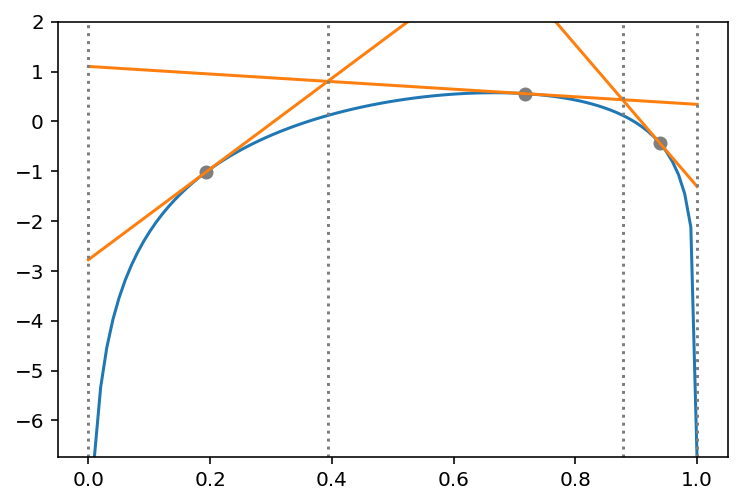

In [120]:
intersections = [compute_intersect(z1, z2, p.logpdf) for z1, z2 in zip(z[:-1], z[1:])]

plt.plot(xrange, p_logpdf, label="pdf")
plt.scatter(z0, p.logpdf(z0), color="tab:gray")

for zi, li in zip(z, lambda_n):
    y1 = (zrange - zi) * li + p.logpdf(zi)
    plt.plot(zrange, y1, c="tab:orange")
    
for x_intersect in [0] + intersections + [1]:
    plt.axvline(x=x_intersect, c="tab:gray", linestyle="dotted")
plt.ylim(lower_bound, 2);

Our first log-approximation is given by

$$
    \log\tilde q(z) = \log p(z_n) + \lambda_n (z - z_n)
$$


With
$$
    \lambda_n = \frac{d}{dz}\log p(z)\big\vert_{z=z_n}
$$

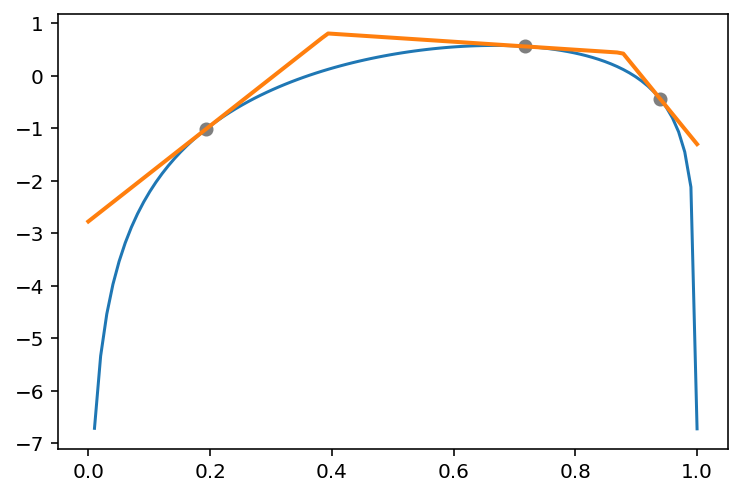

In [121]:
f_approx = f_approx_gen(z, p.logpdf)
plt.plot(xrange, p_logpdf, label="pdf")
plt.plot(xrange, f_approx(xrange), linewidth=2)
plt.scatter(z0, p.logpdf(z0), color="tab:gray")

With non-normalized probabilistic approximation given by

$$
    \tilde q(z) = p(z_n)\exp\big(\lambda_n (z - z_n)\big)
$$

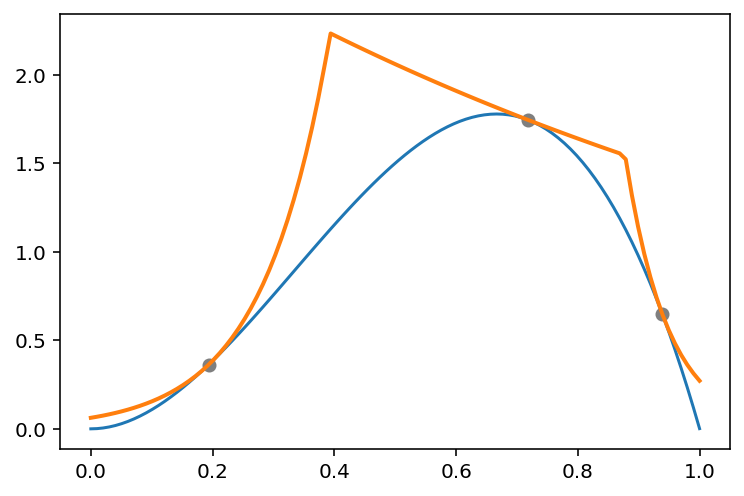

In [122]:
log_f_approx = f_approx_gen(z, p.logpdf)
def f_approx(x): return np.exp(log_f_approx(x))
plt.plot(xrange, p.pdf(xrange), label="pdf")
plt.plot(xrange, f_approx(xrange), linewidth=2)
plt.scatter(z0, p.pdf(z0), color="tab:gray")

The normalization coefficient $Z_q$ is given by

$$
    Z_q = \sum_{n=1}^{N_0}p(z_n)\int_{i_{n-1}}^{i^{n}} \exp\big(\lambda_n (z - z_n)\big) dz
$$

where
* $i_{n-1}$ is the lower bound for the part-function defined over the $n$-th observation: either an intersection point or lower bound of the domain.
* $i_n$ is the upper bound for the part-function defined over the $n$-th observation: either an intersection point or the upper bound of the domain.

In [123]:
quad(f_approx, 0, intersections[0])

(0.23852225944672836, 2.6481290432337306e-15)

In [124]:
l1 = lambda_n[0]
(f_approx(intersections[0]) - f_approx(0)) / l1

0.23852225944672847

In [125]:
quad(f_approx, intersections[0], intersections[1])

(0.9048232703888462, 1.0045556280023307e-14)

In [126]:
l1 = lambda_n[1]
(f_approx(intersections[1]) - f_approx(intersections[0])) / l1

0.9048232703888461

In [127]:
Z_norm, err = quad(f_approx, 0, 1)
def q_dist(x): return f_approx(x) / Z_norm

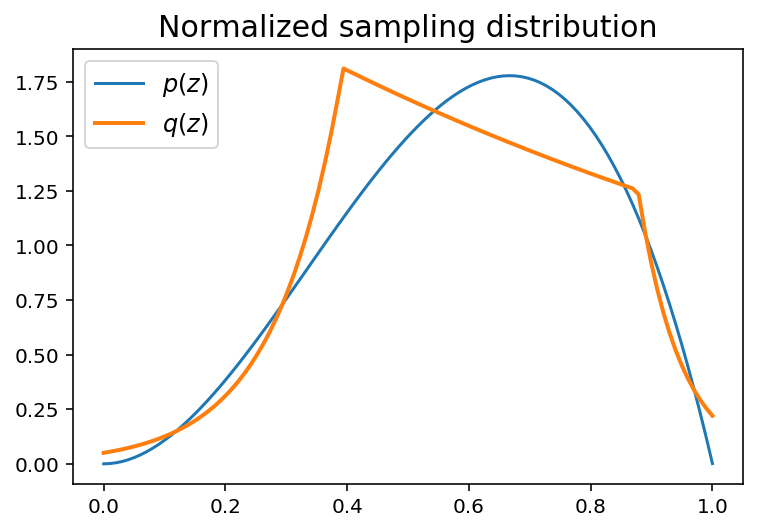

In [128]:
plt.plot(xrange, p.pdf(xrange), label="$p(z)$")
plt.plot(xrange, q_dist(xrange), linewidth=2, label="$q(z)$")
plt.legend(fontsize=12)
plt.title("Normalized sampling distribution", fontsize=15);

In [21]:
%%time
zrange = np.linspace(0, 1, 50)
empirical_cdf = np.empty_like(zrange)

for ix, zval in enumerate(zrange):
    qi = quad(q_dist, 0, zval)[0]
    empirical_cdf[ix] = qi

CPU times: user 1min 26s, sys: 1.01 s, total: 1min 27s
Wall time: 1min 26s


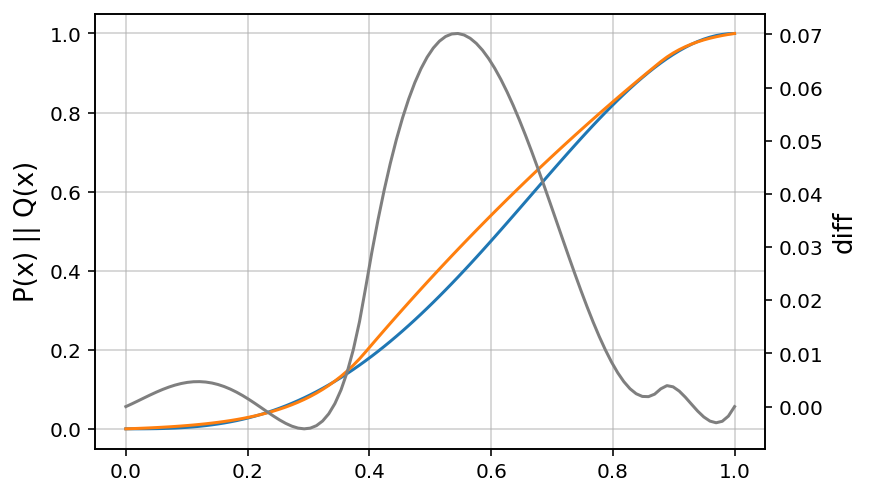

In [22]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(zrange, p.cdf(zrange))
ax.plot(zrange, empirical_cdf)
ax2.plot(zrange, empirical_cdf - p.cdf(zrange), c="tab:gray")
ax.grid(alpha=0.6)
ax2.set_ylabel("diff", fontsize=13);
ax.set_ylabel("P(x) || Q(x)", fontsize=13);

## Sampling from $q(z)$

if $y\sim\text{U}(0, 1)$, then

$$
    z = \frac{1}{\lambda_n}\log\left(\frac{Z_q\lambda_n\exp(\lambda_nz_n)(y - I_{i_{n-1}})}{p(z_n)} + \exp\big(\lambda_ni_{n-1}\big)\right)
$$

Where
* $I_{i_{n-1}} = P(z \leq i_{n-1})$
* $Z_q$ is the normalization coefficient for the $q$ distribution

In [129]:
def q_cdf_nonorm(x, f, z_obs, lb, ub):
    """
    Parameters
    ----------
    intersections: list
        Set of intersecting points
    lb: float
        Lower bound of the distribution
    ub: float
        Upper bound of the distribution
    """
    intersections = [compute_intersect(z1, z2, p.logpdf) for z1, z2 in zip(z_obs[:-1], z_obs[1:])]
    regions = np.array([lb] + intersections + [ub])
    
    if x <= lb:
        return 0
    else:
        I = 0
        bounds = regions[x >= regions]
        pair_bounds = list(zip(bounds[:-1], bounds[1:]))
        for ix, (b0, b1) in enumerate(pair_bounds):
            ln = finite_approx(p.logpdf, z_obs[ix])
            I += (f(b1) - f(b0)) / ln
        if len(pair_bounds) == 0:
            ix = -1
        if x < ub:
            ln = finite_approx(p.logpdf, z_obs[ix + 1])
            I += (f(x) - f(bounds[-1])) / ln
        return I

In [130]:
Z_norm = q_cdf_nonorm(1, f_approx, z, 0, 1)

In [131]:
def make_q_cdf(f, z_obs, lb, ub):
    Z_norm = q_cdf_nonorm(ub, f, z_obs, lb, ub)
    def q(x):
        return q_cdf_nonorm(x, f, z_obs, lb, ub) / Z_norm
    return q
    
q_cdf = make_q_cdf(f_approx, z, 0, 1)

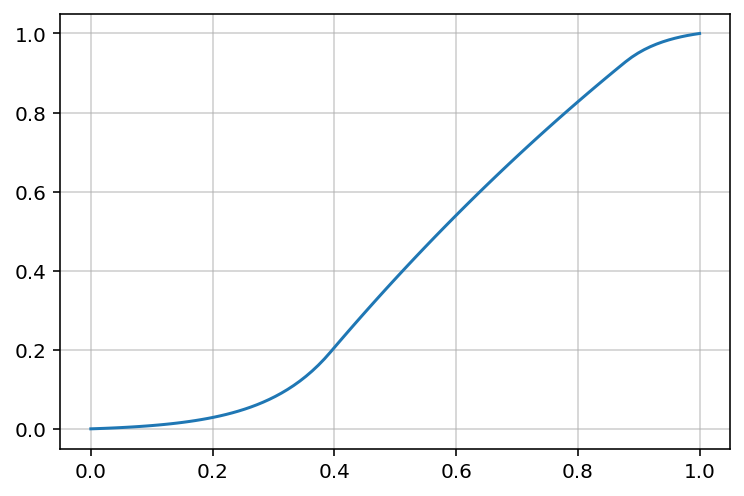

In [132]:
cdf = [q_cdf(zi) for zi in zrange]

plt.plot(zrange, cdf)
plt.grid(alpha=0.6)

In [133]:
lb, ub = 0, 1
regions = np.array([lb] + intersections + [ub])

In [134]:
def q_inv(y, z_obs, logp, regions, Z_norm):
    """
    Parameters
    ----------
    y: float
        random variable from a U(0, 1) distribution
    """
    i0 = regions[y >= regions].max()
    c = q_cdf(i0)

    if y <= z_obs.min():
        zn = z_obs[0]
    elif y >= z_obs.max():
        zn = z_obs[-1]
    else:
        # find intermediate points
        z1 = z_obs[y >= z_obs].max()
        z2 = z_obs[y <= z_obs].min()

        intersect = compute_intersect(z1, z2, logp)

        if y < intersect:
            zn = z1
        else:
            zn = z2

    ln = finite_approx(p.logpdf, zn)
    z_samp = np.log(ln * Z_norm * (y - c) * np.exp(ln * zn) / p.pdf(zn) + np.exp(ln * i0)) / ln
    return z_samp

In [137]:
%%time
yvals = random_sample(1_000)
z_samples = []
for y in yvals:
    z_samp = q_inv(y, z, p.logpdf, regions, Z_norm)
    z_samples.append(z_samp)

CPU times: user 9.1 s, sys: 140 ms, total: 9.24 s
Wall time: 9.22 s


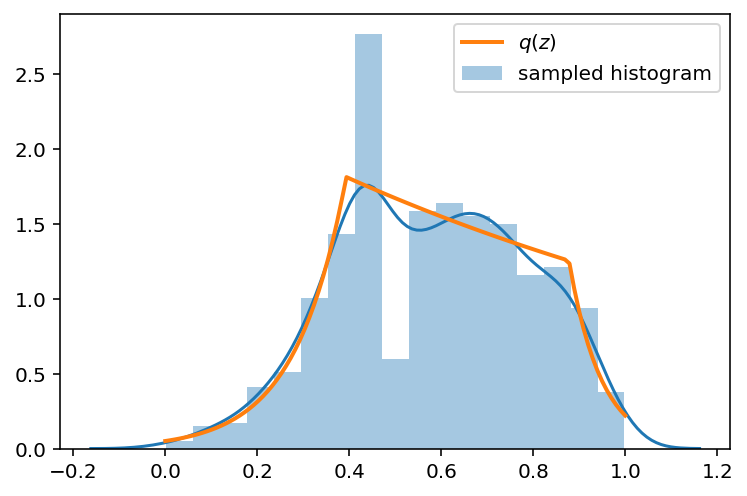

In [138]:
sns.distplot(z_samples, label="sampled histogram")
plt.plot(xrange, q_dist(xrange), linewidth=2, label="$q(z)$")
plt.legend();

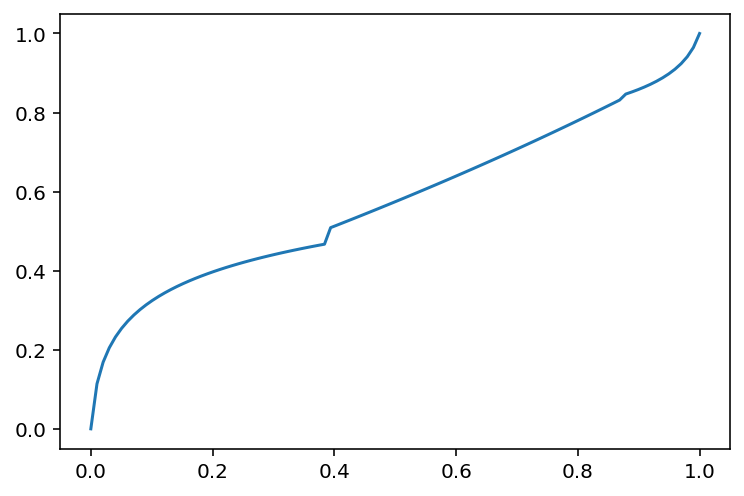

In [140]:
inv_cdf = [q_inv(y, z, p.logpdf, regions, Z_norm) for y in zrange]
plt.plot(zrange, inv_cdf)

# All together

In [143]:
seed(271)
lb, ub = 0, 1
z_obs = np.sort(p.rvs(3))

In [144]:
log_f_approx = f_approx_gen(z_obs, p.logpdf)
def f_approx(x): return np.exp(log_f_approx(x))

Z_norm = q_cdf_nonorm(1, f_approx, z_obs, 0, 1)
q_cdf = make_q_cdf(f_approx, z_obs, 0, 1)
cdf = [q_cdf(zi) for zi in zrange]

intersections = [compute_intersect(z1, z2, p.logpdf) for z1, z2 in zip(z_obs[:-1], z_obs[1:])]
regions = np.array([lb] + intersections + [ub])

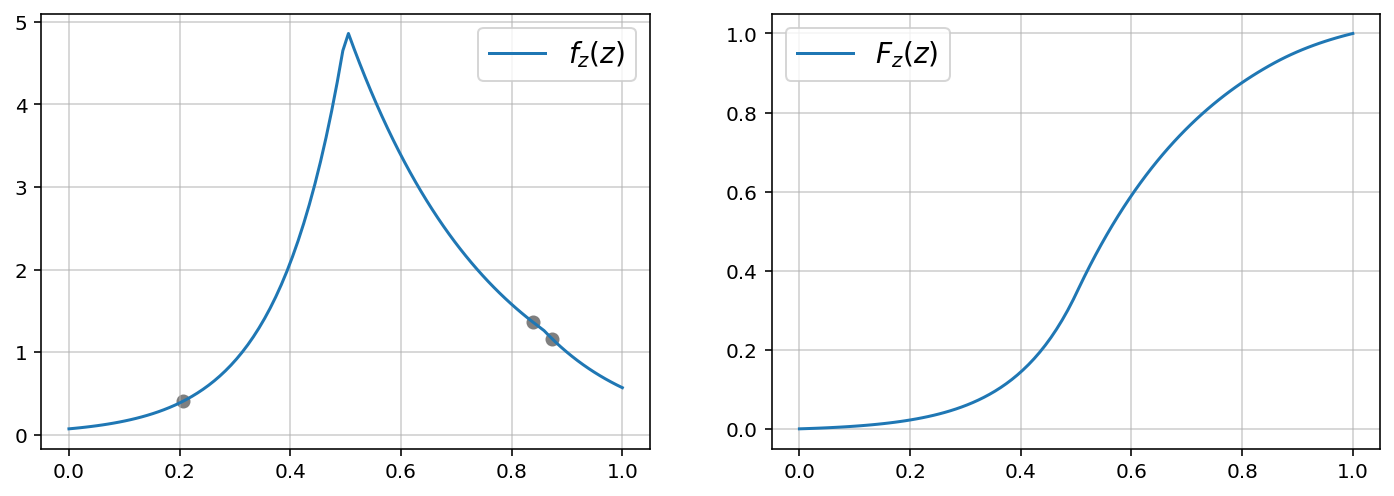

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(z_obs, p.pdf(z_obs), color="tab:gray")
ax[0].plot(xrange, f_approx(xrange), label="$f_z(z)$")
ax[1].plot(zrange, cdf, label="$F_z(z)$")

for axi in ax:
    axi.grid(alpha=0.6)
    axi.legend(fontsize=14)

In [159]:
%%time
yvals = random_sample(1_000)
z_samples = []
for y in yvals:
    z_samp = q_inv(y, z_obs, p.logpdf, regions, Z_norm)
    z_samples.append(z_samp)

CPU times: user 7.58 s, sys: 89.8 ms, total: 7.67 s
Wall time: 7.64 s


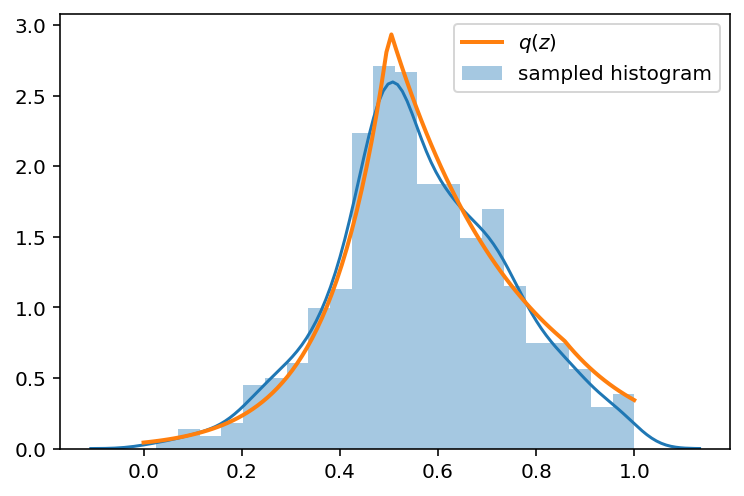

In [160]:
sns.distplot(z_samples, label="sampled histogram")
plt.plot(xrange, q_dist(xrange), linewidth=2, label="$q(z)$")
plt.legend();